### Doublet calculation.  

In [2]:
CANCER_TYPE = "HGG"

In [3]:
library(Seurat)

Loading required package: SeuratObject

Loading required package: sp

'SeuratObject' was built with package 'Matrix' 1.7.0 but the current
version is 1.7.1; it is recomended that you reinstall 'SeuratObject' as
the ABI for 'Matrix' may have changed


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t




In [27]:

library(DoubletFinder)
library(dplyr)

callDoubletFinder <- function(seuratObj) {
  # Pre-process seurat object with standard seurat workflow
  suppressMessages(
  invisible(capture.output({
    seuratObj <- NormalizeData(seuratObj)
    seuratObj <- FindVariableFeatures(seuratObj)
    seuratObj <- ScaleData(seuratObj)
    seuratObj <- RunPCA(seuratObj)
    }))
  )

  # Find significant PCs
  stdv <- seuratObj[["pca"]]@stdev
  sum.stdv <- sum(seuratObj[["pca"]]@stdev)
  percent.stdv <- (stdv / sum.stdv) * 100
  cumulative <- cumsum(percent.stdv)
  co1 <- which(cumulative > 90 & percent.stdv < 5)[1]
  co2 <- sort(which((percent.stdv[1:length(percent.stdv) - 1] -
                       percent.stdv[2:length(percent.stdv)]) > 0.1),
              decreasing = T)[1] + 1
  min.pc <- min(co1, co2)
  min.pc

  suppressMessages(
  invisible(capture.output({
    # finish pre-processing
    seuratObj <- RunUMAP(seuratObj, dims = 1:min.pc)
    seuratObj <- FindNeighbors(object = seuratObj, dims = 1:min.pc)             
    seuratObj <- FindClusters(object = seuratObj, resolution = 0.1)
    }))
  )
  

  sweep.list <- paramSweep(seuratObj, PCs = 1:min.pc, num.cores = 1)
  sweep.stats <- summarizeSweep(sweep.list)
  bcmvn <- find.pK(sweep.stats)

  # Optimal pK is the max of the bomodality coefficent (BCmvn) distribution
  bcmvn.max <- bcmvn[which.max(bcmvn$BCmetric),]
  optimal.pk <- bcmvn.max$pK
  optimal.pk <- as.numeric(levels(optimal.pk))[optimal.pk]

  ## Homotypic doublet proportion estimate
  annotations <- seuratObj@meta.data$seurat_clusters
  homotypic.prop <- modelHomotypic(annotations)
  nExp.poi <- round(optimal.pk * nrow(seuratObj@meta.data)) ## Assuming 7.5% doublet formation rate - tailor for your dataset
  nExp.poi.adj <- round(nExp.poi * (1 - homotypic.prop))

  suppressMessages(
  invisible(capture.output({
    # run DoubletFinder
    seuratObj <- doubletFinder(seu = seuratObj,
                                   PCs = 1:min.pc,
                                   pK = optimal.pk,
                                   nExp = nExp.poi.adj)
    }))
  )

  seuratObj@meta.data <- seuratObj@meta.data %>%
  rename_with(~ gsub("pANN.*", "pANN", .), matches("pANN")) %>%
  rename_with(~ gsub("DF.*", "DFC", .), matches("DF"))

  return(seuratObj)

}

In [20]:
subsample_single <- function(seurat_obj, frac) {
    all_cells <- Cells(seurat_obj)
    total_cells <- length(all_cells)
    num_cells <- max(1, floor(total_cells * frac))
    sampled_cells <- sample(all_cells, size = num_cells, replace = FALSE)
    seurat_subsampled <- subset(seurat_obj, cells = sampled_cells)
    return(seurat_subsampled)
}



In [ ]:
seurat_list <- list()
dir <- "../Generate_Seurat_Object/out"
file_list  <- Sys.glob(file.path(dir, paste0("*_",CANCER_TYPE,".rds")))
for (i in seq_along(file_list)){
    file <- file_list[[i]]
    print(file)
    seurat_obj <- subsample_single(readRDS(file), 0.10)
    seurat_list[[basename(file)]] <- seurat_obj
}

In [24]:
sum = 0
for (name in names(seurat_list)){
    cells_n = dim(seurat_list[[name]])[2]
    print(cells_n)
    sum = sum + cells_n
}
print(sum)
    

[1] 341
[1] 343
[1] 477
[1] 130
[1] 850
[1] 120
[1] 357
[1] 592
[1] 365
[1] 1156
[1] 1263
[1] 1052
[1] 987
[1] 102
[1] 536
[1] 989
[1] 394
[1] 905
[1] 263
[1] 156
[1] 164
[1] 276
[1] 48
[1] 147
[1] 106
[1] 442
[1] 78
[1] 200
[1] 139
[1] 53
[1] 92
[1] 90
[1] 61
[1] 50
[1] 36
[1] 215
[1] 22
[1] 543
[1] 742
[1] 1312
[1] 644
[1] 775
[1] 17613


[1] "=================="
[1] "GSM6432703_BT2016062_HGG.rds"


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Warning message:
"package 'fields' was built under R version 4.4.1"
Warning message:
"package 'spam' was built under R version 4.4.1"


[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."
[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "S

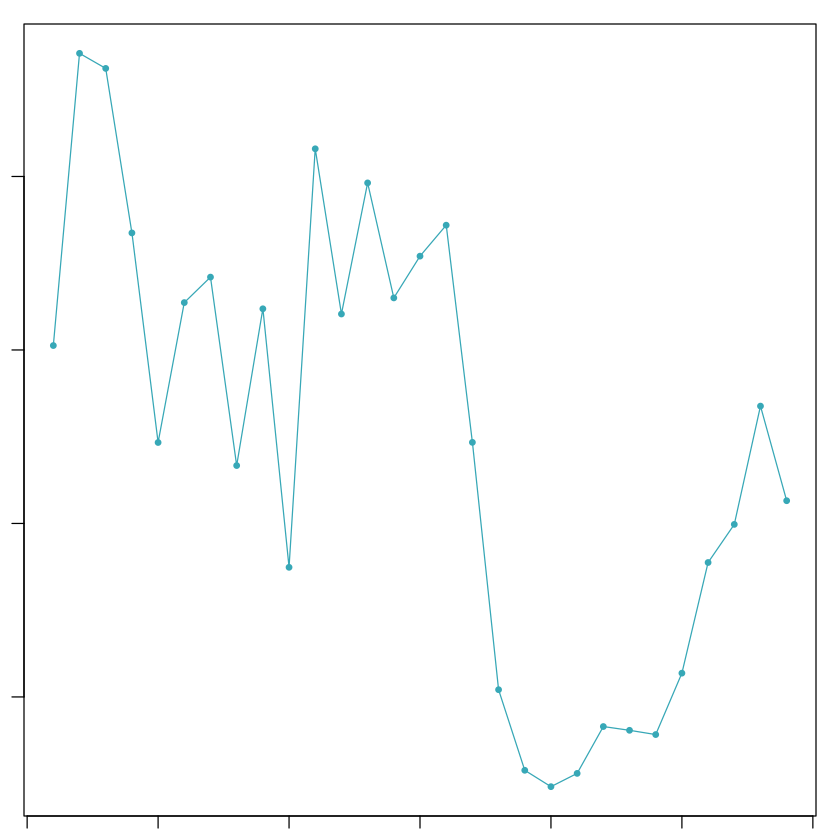

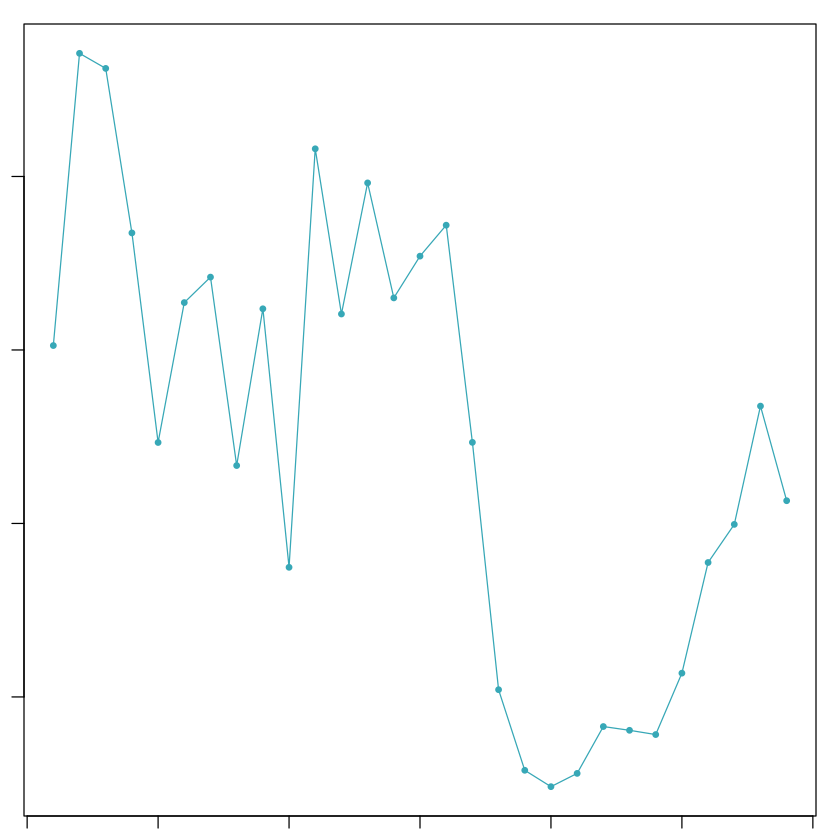

In [28]:
library(dplyr)
library(DoubletFinder)

for (name in names(seurat_list)){
    print("==================")
    print(name)
    suppressMessages((
        seurat_list[[name]] <- callDoubletFinder(seurat_list[[name]])
    ))
}


In [34]:
for (name in names(seurat_list)) {
    cat("\n", name, dim(seurat_list[[name]]@meta.data))
}


 GSM6432703_BT2016062_HGG.rds 775 8
 GSM6432704_BT2018022_HGG.rds 775 8
 GSM6432705_P-1190_S-1197_HGG.rds 775 8
 GSM6432706_P-1569_S-1569_HGG.rds 775 8
 GSM6432723_P-6117_S-8370_HGG.rds 775 8
 GSM6432724_P-6166_S-8321_HGG.rds 775 8
 GSM6432725_P-6240_S-8628_HGG.rds 775 8
 GSM6432730_P-6292_S-8579_HGG.rds 775 8
 GSM6432731_P-6308_S-8632_HGG.rds 775 8
 GSM6432735_P-6337_S-8821_HGG.rds 775 8
 GSM6432737_P-6431_S-8842_HGG.rds 775 8
 GSM6432738_P-6519_S-9084_HGG.rds 775 8
 GSM6432739_P-6640_S-9581_HGG.rds 775 8
 GSM6934152_PA1_HGG.rds 775 8
 GSM6934153_PA2_HGG.rds 775 8
 GSM6934155_PA4_HGG.rds 775 8
 GSM6934156_PA5_HGG.rds 775 8
 GSM6934157_PMA1_HGG.rds 775 8
 GSM7305260_834_HGG.rds 775 8
 GSM7305261_868_HGG.rds 775 8
 GSM7305262_905_HGG.rds 775 8
 GSM7305263_910_HGG.rds 775 8
 GSM7305264_954_HGG.rds 775 8
 GSM7305265_968_HGG.rds 775 8
 GSM7305266_1107_HGG.rds 775 8
 GSM7305267_1144_HGG.rds 775 8
 GSM7305268_1187_HGG.rds 775 8
 GSM7305269_1190_HGG.rds 775 8
 GSM7305270_1196_HGG.rds 775 8
 

In [33]:
head(seurat_list[["GSM7305278_1463_B_HGG.rds"]]@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,CANCER_TYPE,RNA_snn_res.0.1,seurat_clusters,pANN,DFC
,<fct>,<dbl>,<int>,<chr>,<fct>,<fct>,<dbl>,<chr>
GSM7816071_SPA1_AAACCTGCATCTGGTA-1,GSM7816071,11496,3648,HGG,0,0,0.38709677,Singlet
GSM7816071_SPA1_AAACCTGGTCCGAACC-1,GSM7816071,524,438,HGG,1,1,0.00000000,Singlet
GSM7816071_SPA1_AAACCTGTCCACGACG-1,GSM7816071,4432,2544,HGG,2,2,0.22580645,Singlet
GSM7816071_SPA1_AAACGGGAGGCCCTTG-1,GSM7816071,1336,911,HGG,1,1,0.09677419,Singlet
GSM7816071_SPA1_AAACGGGTCAGGATCT-1,GSM7816071,2979,1528,HGG,0,0,0.03225806,Singlet
GSM7816071_SPA1_AAAGATGTCGTACGGC-1,GSM7816071,11928,3637,HGG,0,0,0.29032258,Singlet


In [32]:
saveRDS(seurat_list, file=paste0("./out/seurat_list_doublet_",CANCER_TYPE,".rds"))